First, load the data,in this notebook we are using the smokoy mountain data as the example

In [1]:
import sys
sys.path.append('./Code')
import loadData 
import RunML
import RunML_continue
import FS

import pandas as pd
import numpy as np
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import pickle

In [2]:
data,burn_label,un_label,duration_label,ASVs,df=loadData.loadSoilData("./Data/merge_proportion_asv_smoky_moutain.csv")

In [3]:
data

array([[1.5786533e-02, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.6912335e-02, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 5.0700000e-05,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        8.2400000e-05, 8.2400000e-05],
       [1.5771320e-03, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]])

In [4]:
data=RunML.normalizingMatrixToRanks(data,cutOff=0.01)
print(np.shape(data))

(59, 1768)


In [5]:
#print(burn_label)
#print(un_label)
#print(duration_label)

Perform multiLabel feature selection, this is done by calculating Kruskal-Wallis H-test on each OTU for each environmental factor, each OTU/ASV is given a weighted h score.

In [6]:
yList=[list(burn_label),list(un_label),list(duration_label)]

In [7]:
burn_label

0      No
1      No
2      No
3      No
4      No
5      No
6      No
7     Yes
8     Yes
9     Yes
10    Yes
11    Yes
12    Yes
13    Yes
14    Yes
15    Yes
16    Yes
17    Yes
18    Yes
19    Yes
20    Yes
21    Yes
22    Yes
23    Yes
24    Yes
25    Yes
26    Yes
27     No
28     No
29     No
30     No
31    Yes
32    Yes
33    Yes
34    Yes
35    Yes
36    Yes
37    Yes
38    Yes
39    Yes
40     No
41     No
42    Yes
43    Yes
44    Yes
45     No
46     No
47    Yes
48    Yes
49     No
50     No
51    Yes
52    Yes
53    Yes
54    Yes
55    Yes
56    Yes
57    Yes
58    Yes
Name: Burn, dtype: object

In [8]:
weights=FS.multiLabelFeatureWeighting(data,yList)

In [9]:
len(weights)

1768

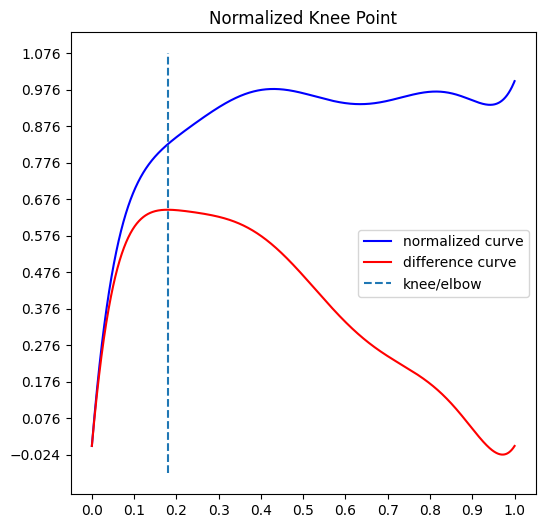

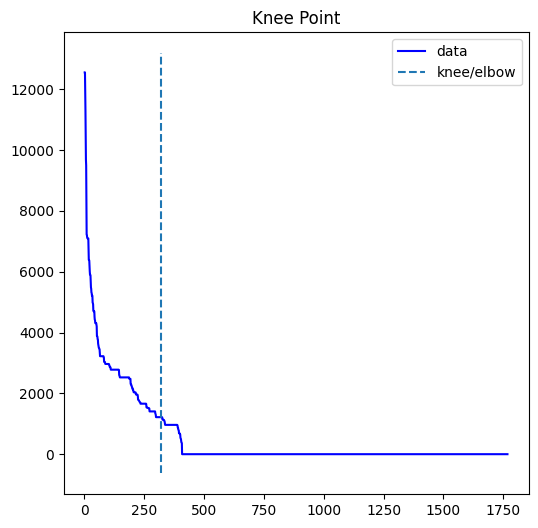

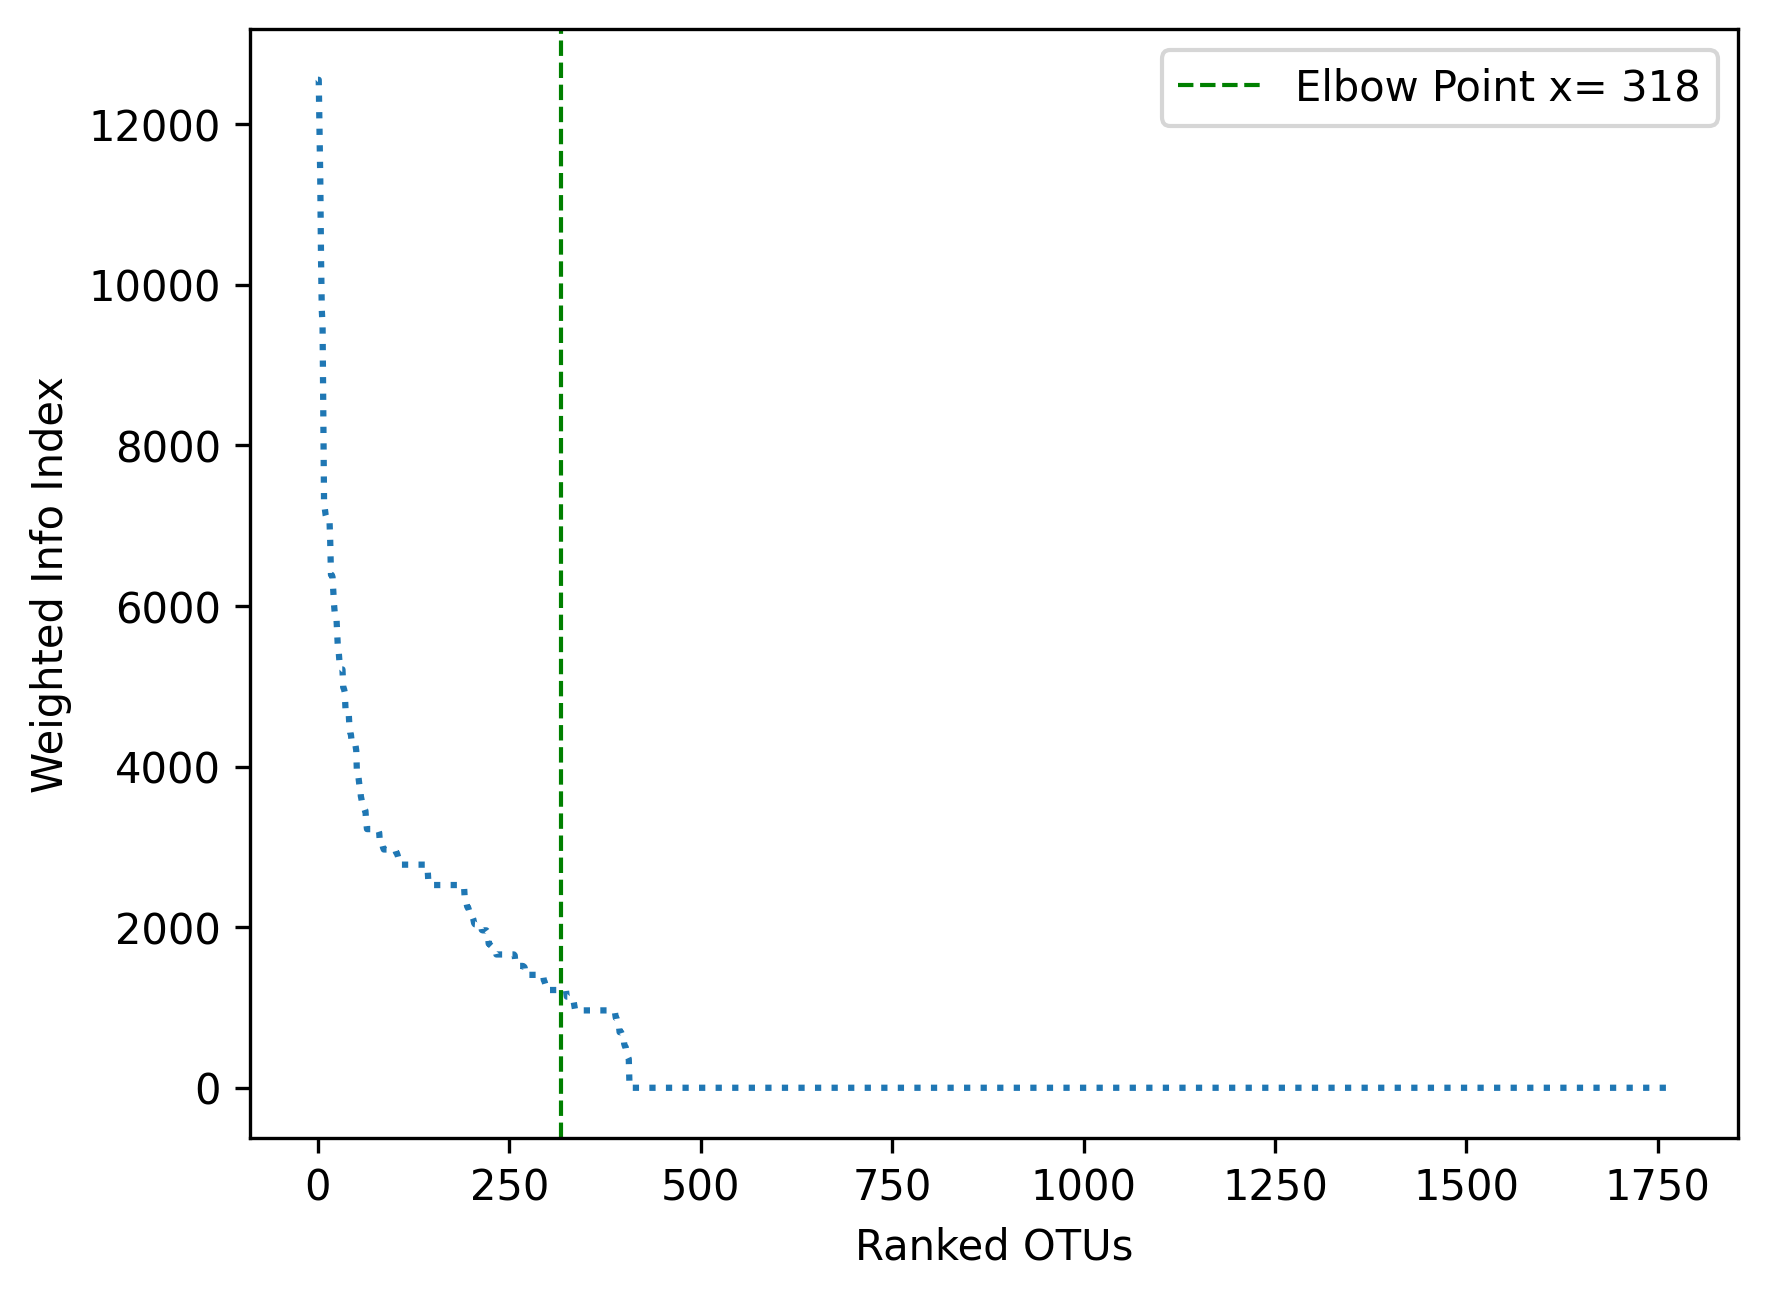

In [10]:
scores=(sorted(weights,reverse=True))
eps=FS.elbowPoint(scores)
FS.plotWeightedIndex(weights,xKnee=eps)

This plot shows that the gain in information decreases as we include more OTUs along the ranks. 

In [11]:
topFeature_selected=eps
print(eps)

X_FS,selectedOTU_index=FS.feature_select(data,yList,topFeature=topFeature_selected)
print (np.shape(X_FS))


318
(59, 318)


In [12]:
print(len(weights))

1768


In [13]:
un_label.value_counts()

UN
Urban      33
Natural    26
Name: count, dtype: int64

In [14]:
targetLabel=un_label

In [15]:
X_lasso = RunML.LassoFeatureSelection(data,targetLabel)# this is depend on the target variable(do not update here)
iter =5
data_subset = {"AllFeatures":data, 
               "SelectMicro": X_FS,
               "Lasso":X_lasso,
               "Random":data
              }
cls = ["RF","SVM"]

In [16]:
dict_cm = RunML_continue.runClassifier_FScompare(data_subsets= data_subset,y= targetLabel,N=iter,classifiers=cls)

             RF_Accuracy    RF_AUC  SVM_Accuracy   SVM_AUC
AllFeatures     0.559091  0.661111      0.678788  0.726349
SelectMicro     0.612121  0.702302      0.678788  0.785714
Lasso           0.540909  0.636508      0.692424  0.725714
Random          0.606061  0.670714      0.605758  0.524460


In [17]:
# Save dictionary to a pickle file
with open('results/dict_cm_smocky_un.pkl', 'wb') as pickle_file:
    pickle.dump(dict_cm, pickle_file)

In [18]:
# Load dictionary from the pickle file
with open('results/dict_cm_smocky_un.pkl', 'rb') as pickle_file:
    dict_cm = pickle.load(pickle_file)

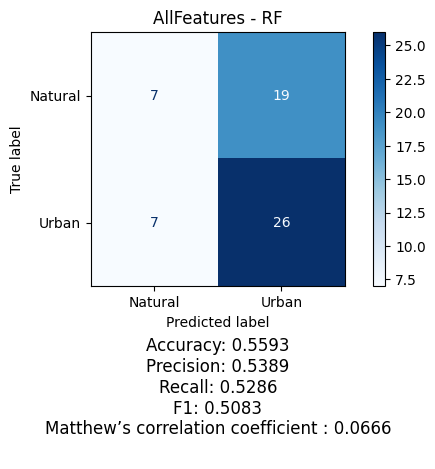

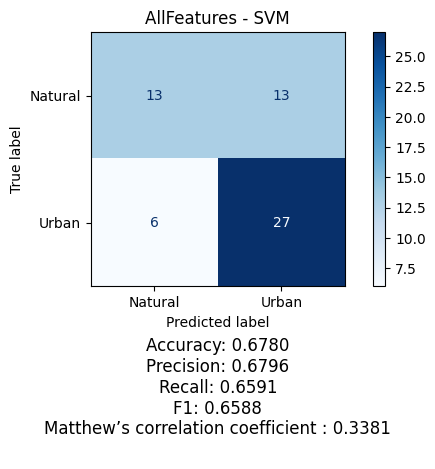

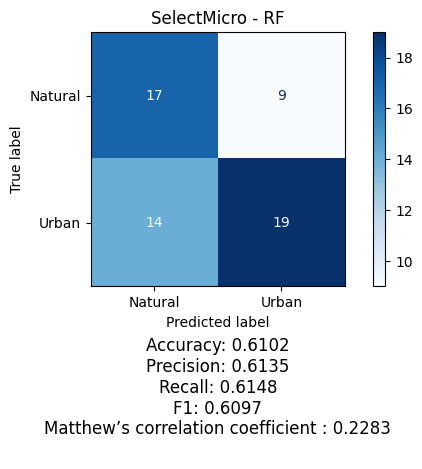

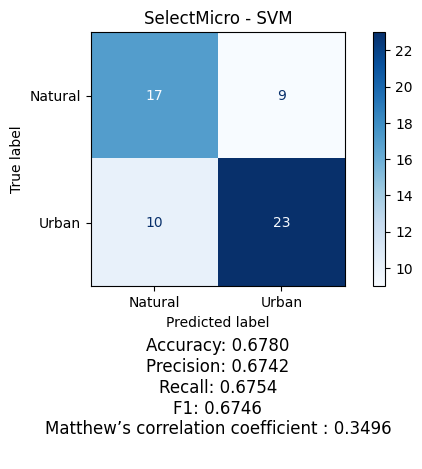

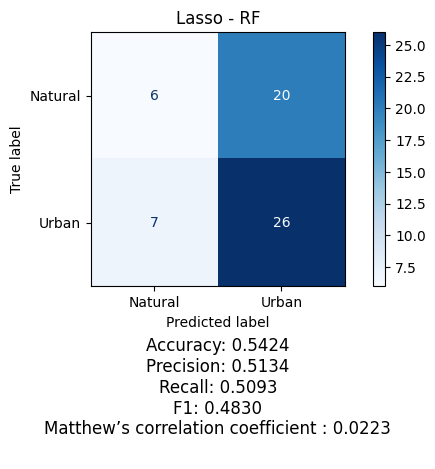

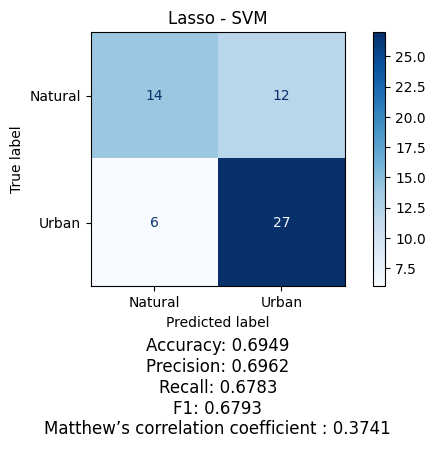

In [19]:
for dataset_name, classifiers in dict_cm.items():
        for classifier_name, labels in classifiers.items():
            actual_labels = labels[0]
            predicted_labels = labels[1]
            RunML_continue.plotmacro_confusion_matrices(actual_labels, predicted_labels,f"{dataset_name} - {classifier_name}")

In [20]:
targetLabel=burn_label
dict_cm_burn = RunML_continue.runClassifier_FScompare(data_subsets= data_subset,y= targetLabel,N=iter,classifiers=cls)

             RF_Accuracy    RF_AUC  SVM_Accuracy   SVM_AUC
AllFeatures     0.780303  0.901157      0.880303  0.922454
SelectMicro     0.863636  0.936806      0.880303  0.949537
Lasso           0.813636  0.903356      0.863636  0.909954
Random          0.809697  0.868333      0.773333  0.771574


In [21]:
# Save dictionary to a pickle file
with open('results/dict_cm_smocky_burn.pkl', 'wb') as pickle_file:
    pickle.dump(dict_cm_burn, pickle_file)

In [22]:
import pickle
# Load dictionary from the pickle file
with open('results/dict_cm_smocky_burn.pkl', 'rb') as pickle_file:
    dict_cm_burn = pickle.load(pickle_file)

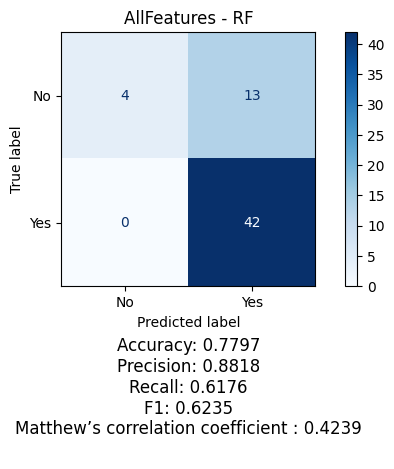

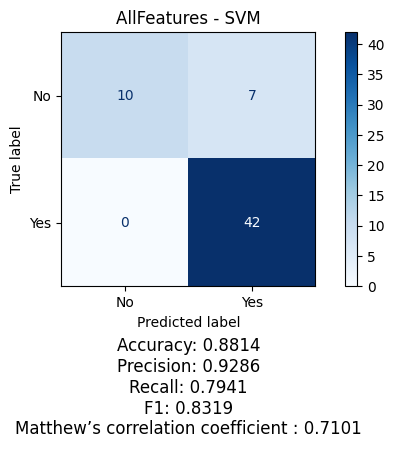

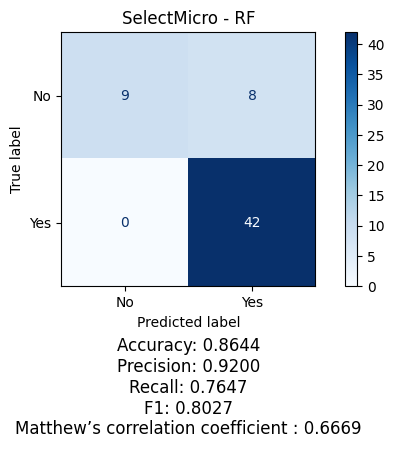

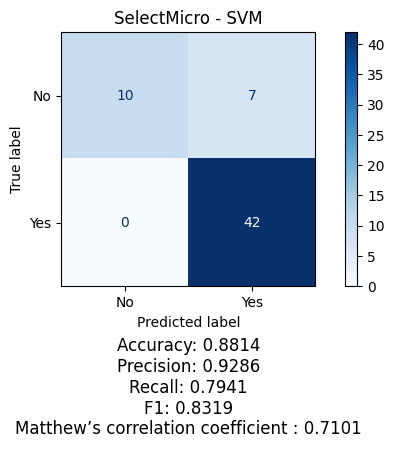

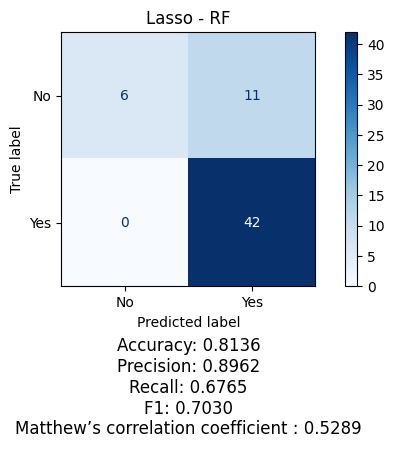

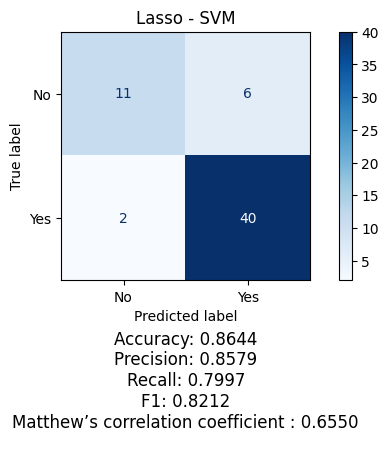

In [23]:
for dataset_name, classifiers in dict_cm_burn.items():
        for classifier_name, labels in classifiers.items():
            actual_labels = labels[0]
            predicted_labels = labels[1]
            RunML_continue.plotmacro_confusion_matrices(actual_labels, predicted_labels,f"{dataset_name} - {classifier_name}")

In [24]:
targetLabel=duration_label
dict_cm_dur = RunML_continue.runClassifier_FScompare(data_subsets= data_subset,y= targetLabel,N=iter,classifiers=cls)

             RF_Accuracy    RF_AUC  SVM_Accuracy   SVM_AUC
AllFeatures     0.524242  0.509375      0.640909  0.628929
SelectMicro     0.575758  0.612857      0.610606  0.653393
Lasso           0.592424  0.603661      0.640909  0.623036
Random          0.570000  0.528964      0.560000  0.522375


In [25]:
import pickle

# Save dictionary to a pickle file
with open('results/dict_cm_smocky_dur.pkl', 'wb') as pickle_file:
    pickle.dump(dict_cm_dur, pickle_file)

In [26]:
import pickle
# Load dictionary from the pickle file
with open('results/dict_cm_smocky_dur.pkl', 'rb') as pickle_file:
    dict_cm_dur = pickle.load(pickle_file)

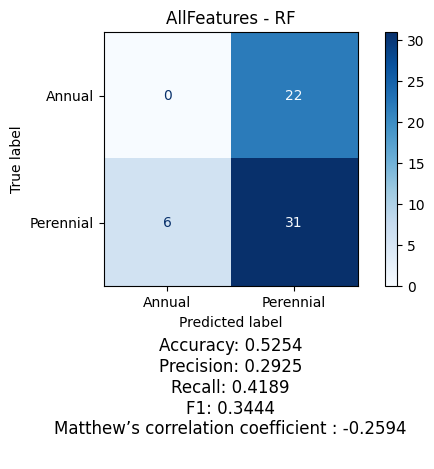

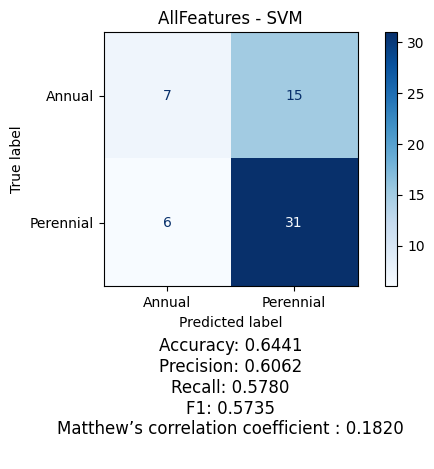

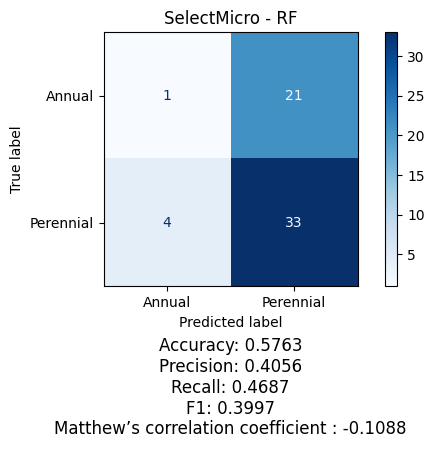

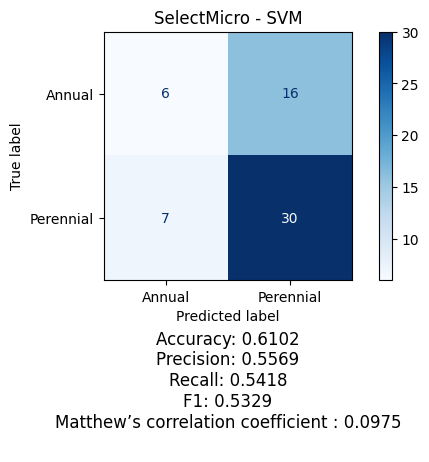

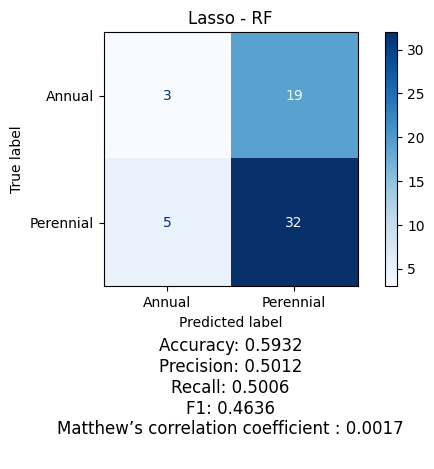

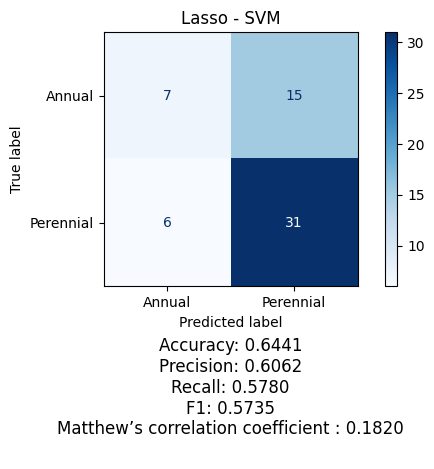

In [27]:
for dataset_name, classifiers in dict_cm_dur.items():
        for classifier_name, labels in classifiers.items():
            actual_labels = labels[0]
            predicted_labels = labels[1]
            RunML_continue.plotmacro_confusion_matrices(actual_labels, predicted_labels,f"{dataset_name} - {classifier_name}")

In [28]:
#RunML_continue.runClassifier_FScompare(data_subsets= data_subset,y= targetLabel,N=iter,classifiers=cls)

## compare the first 15 index

{'No', 'Yes'}
42 17


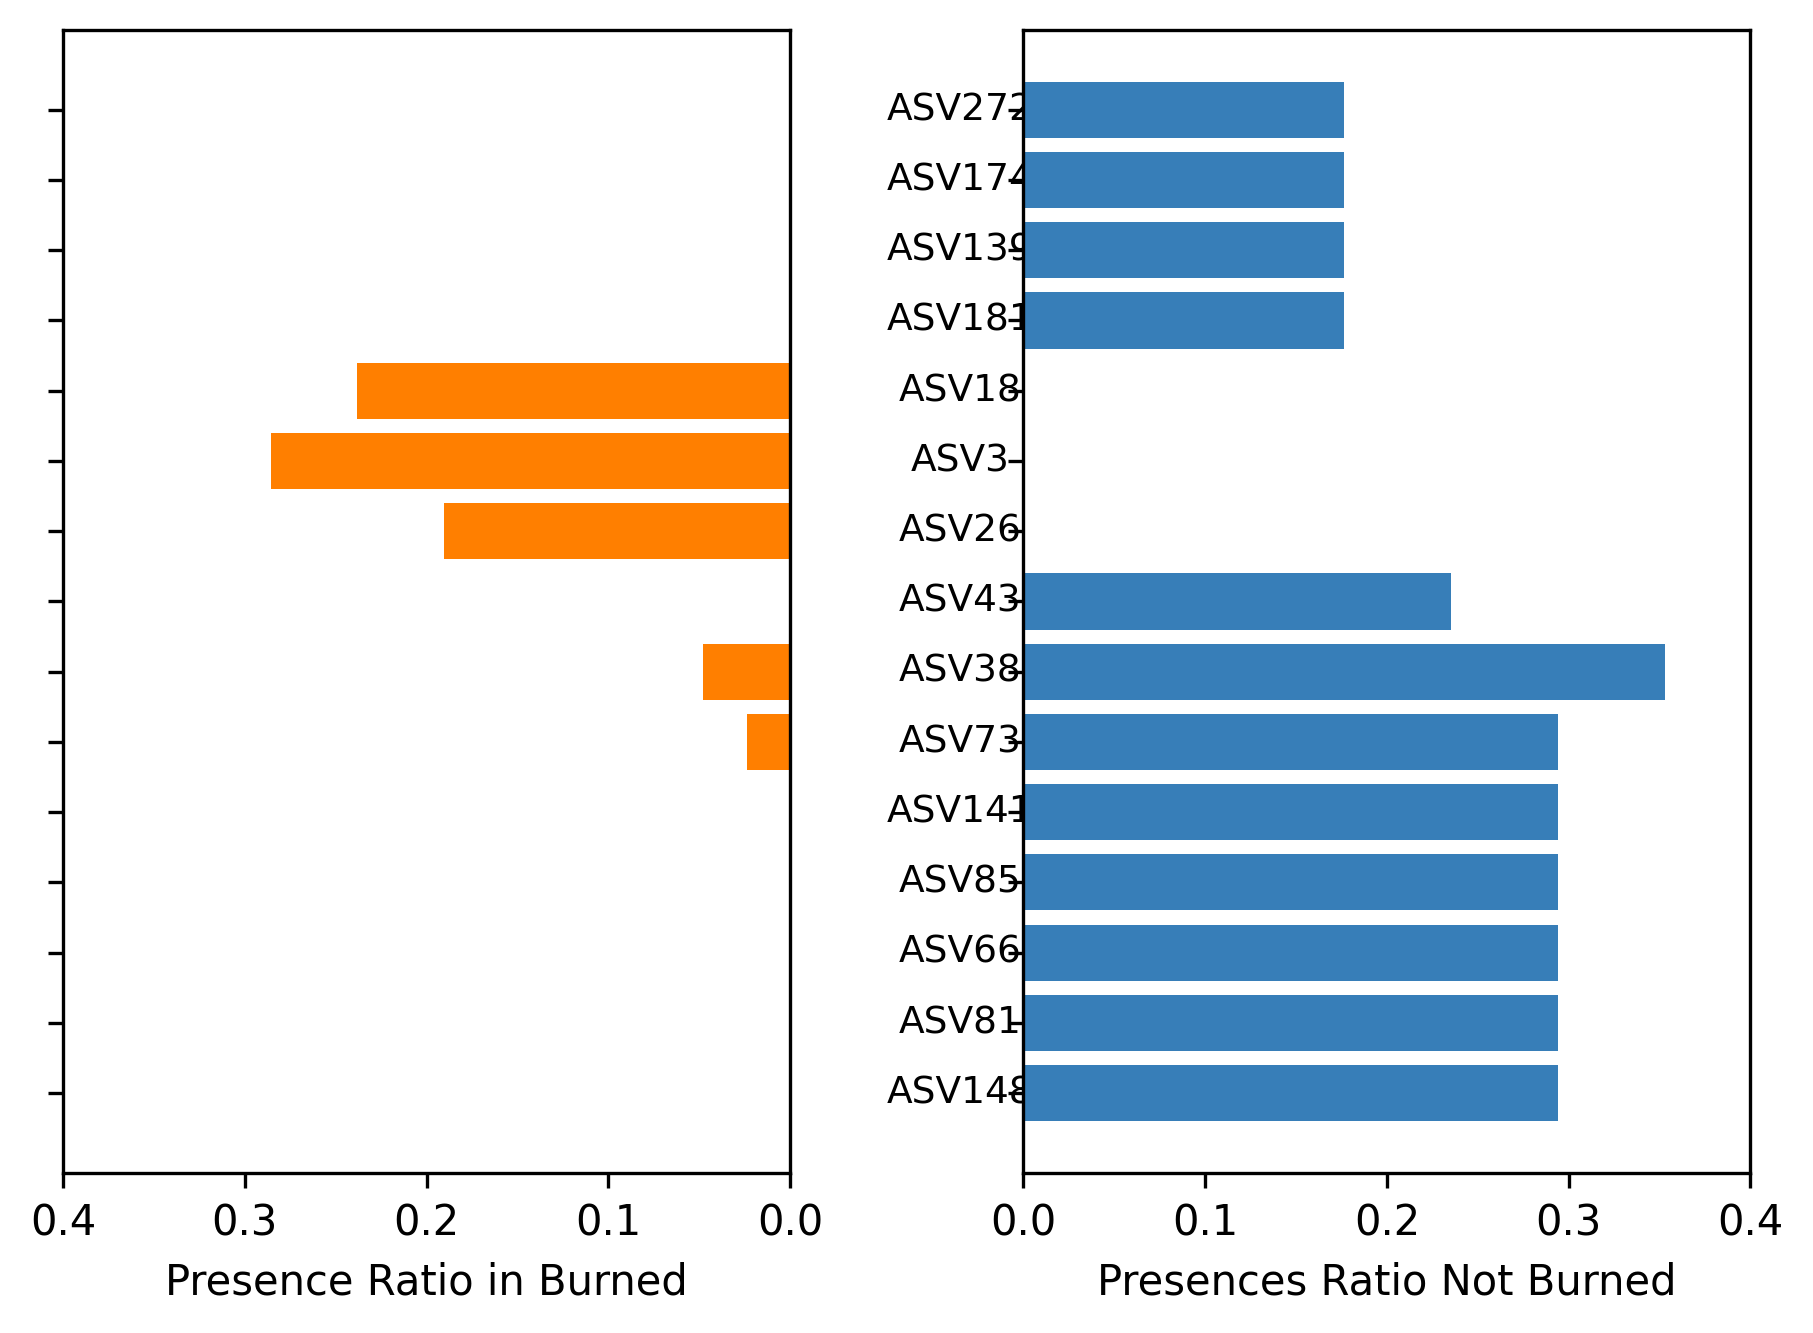

{'Natural', 'Urban'}
33 26


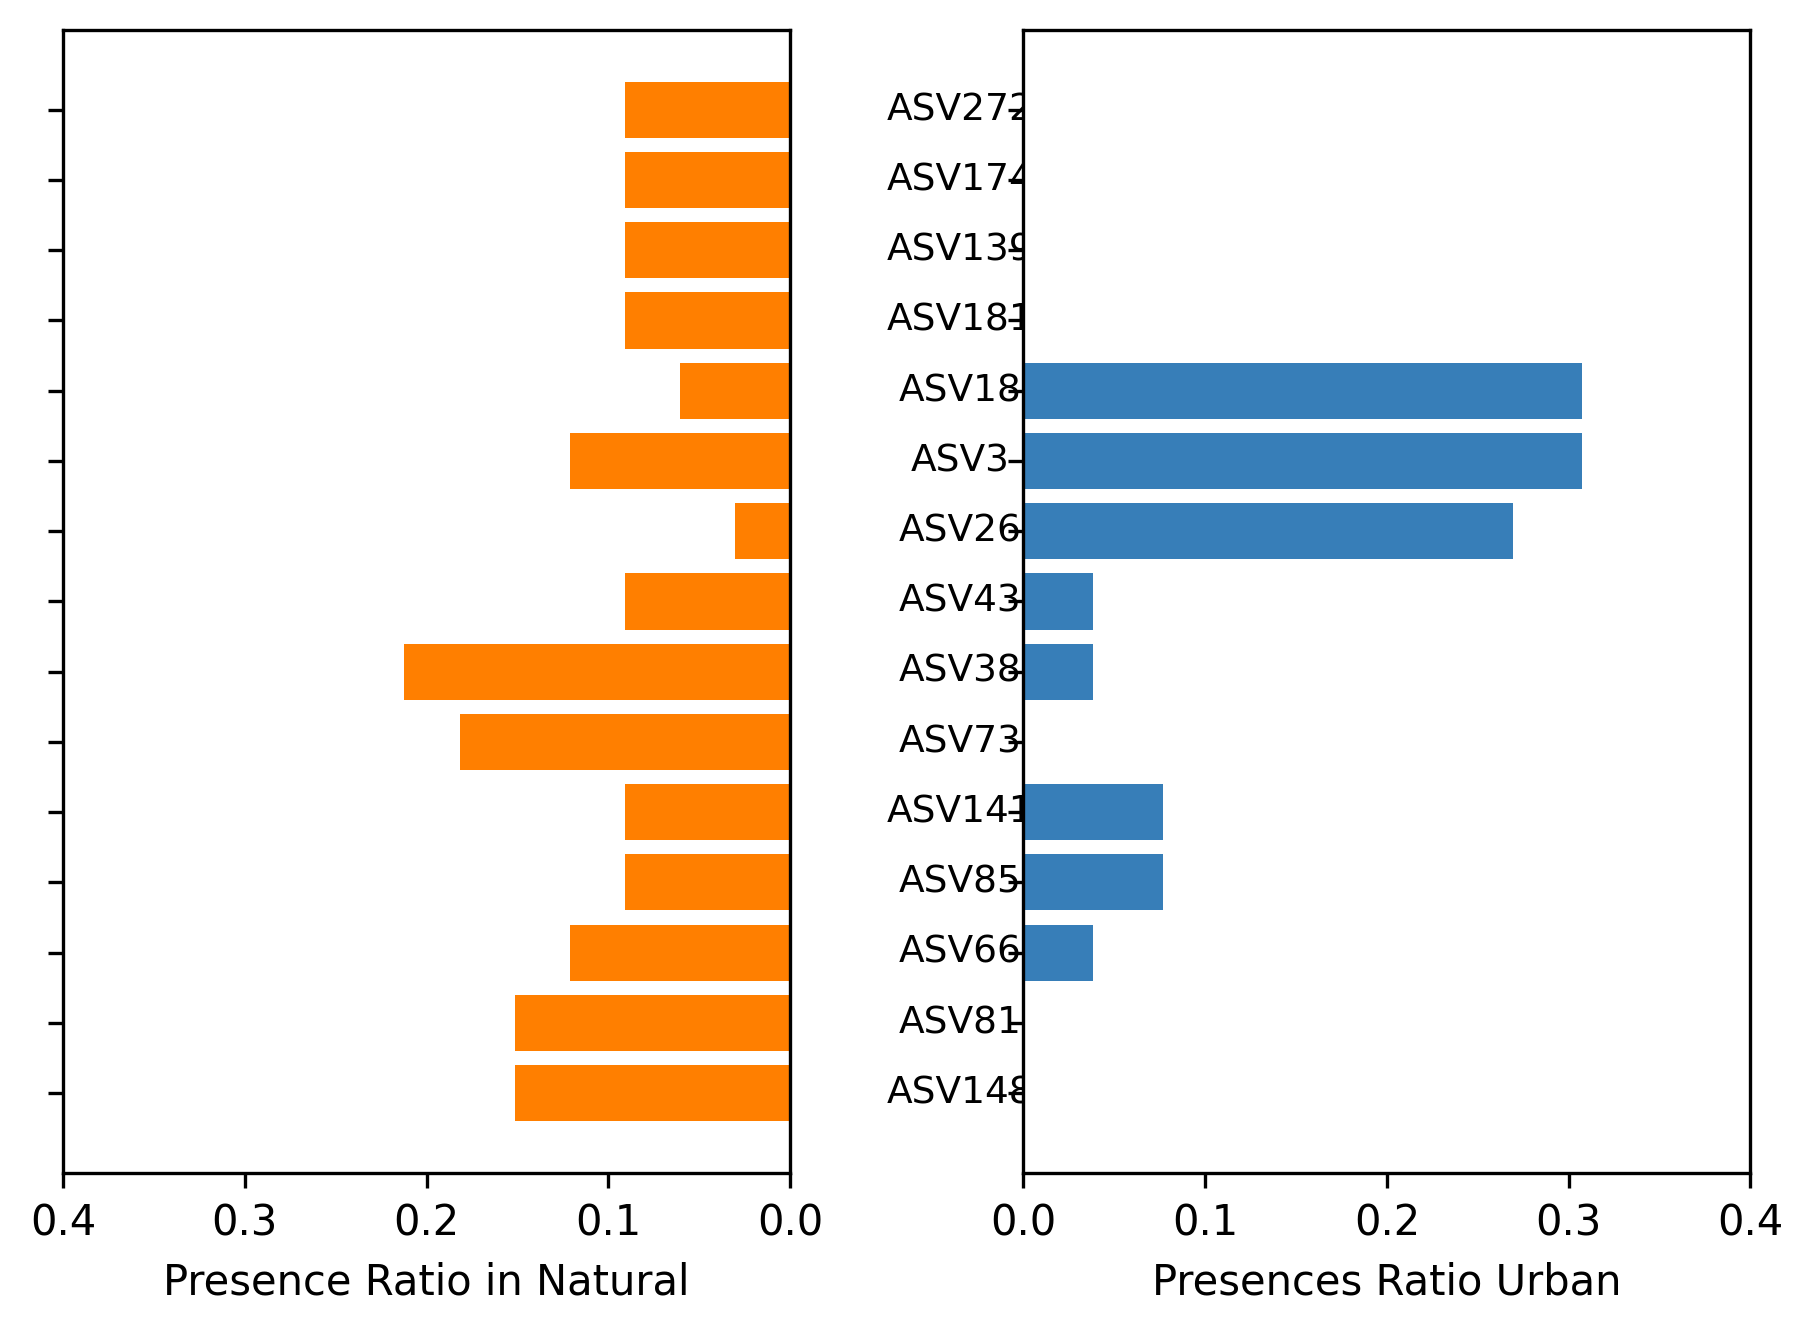

{'Perennial', 'Annual'}
22 37


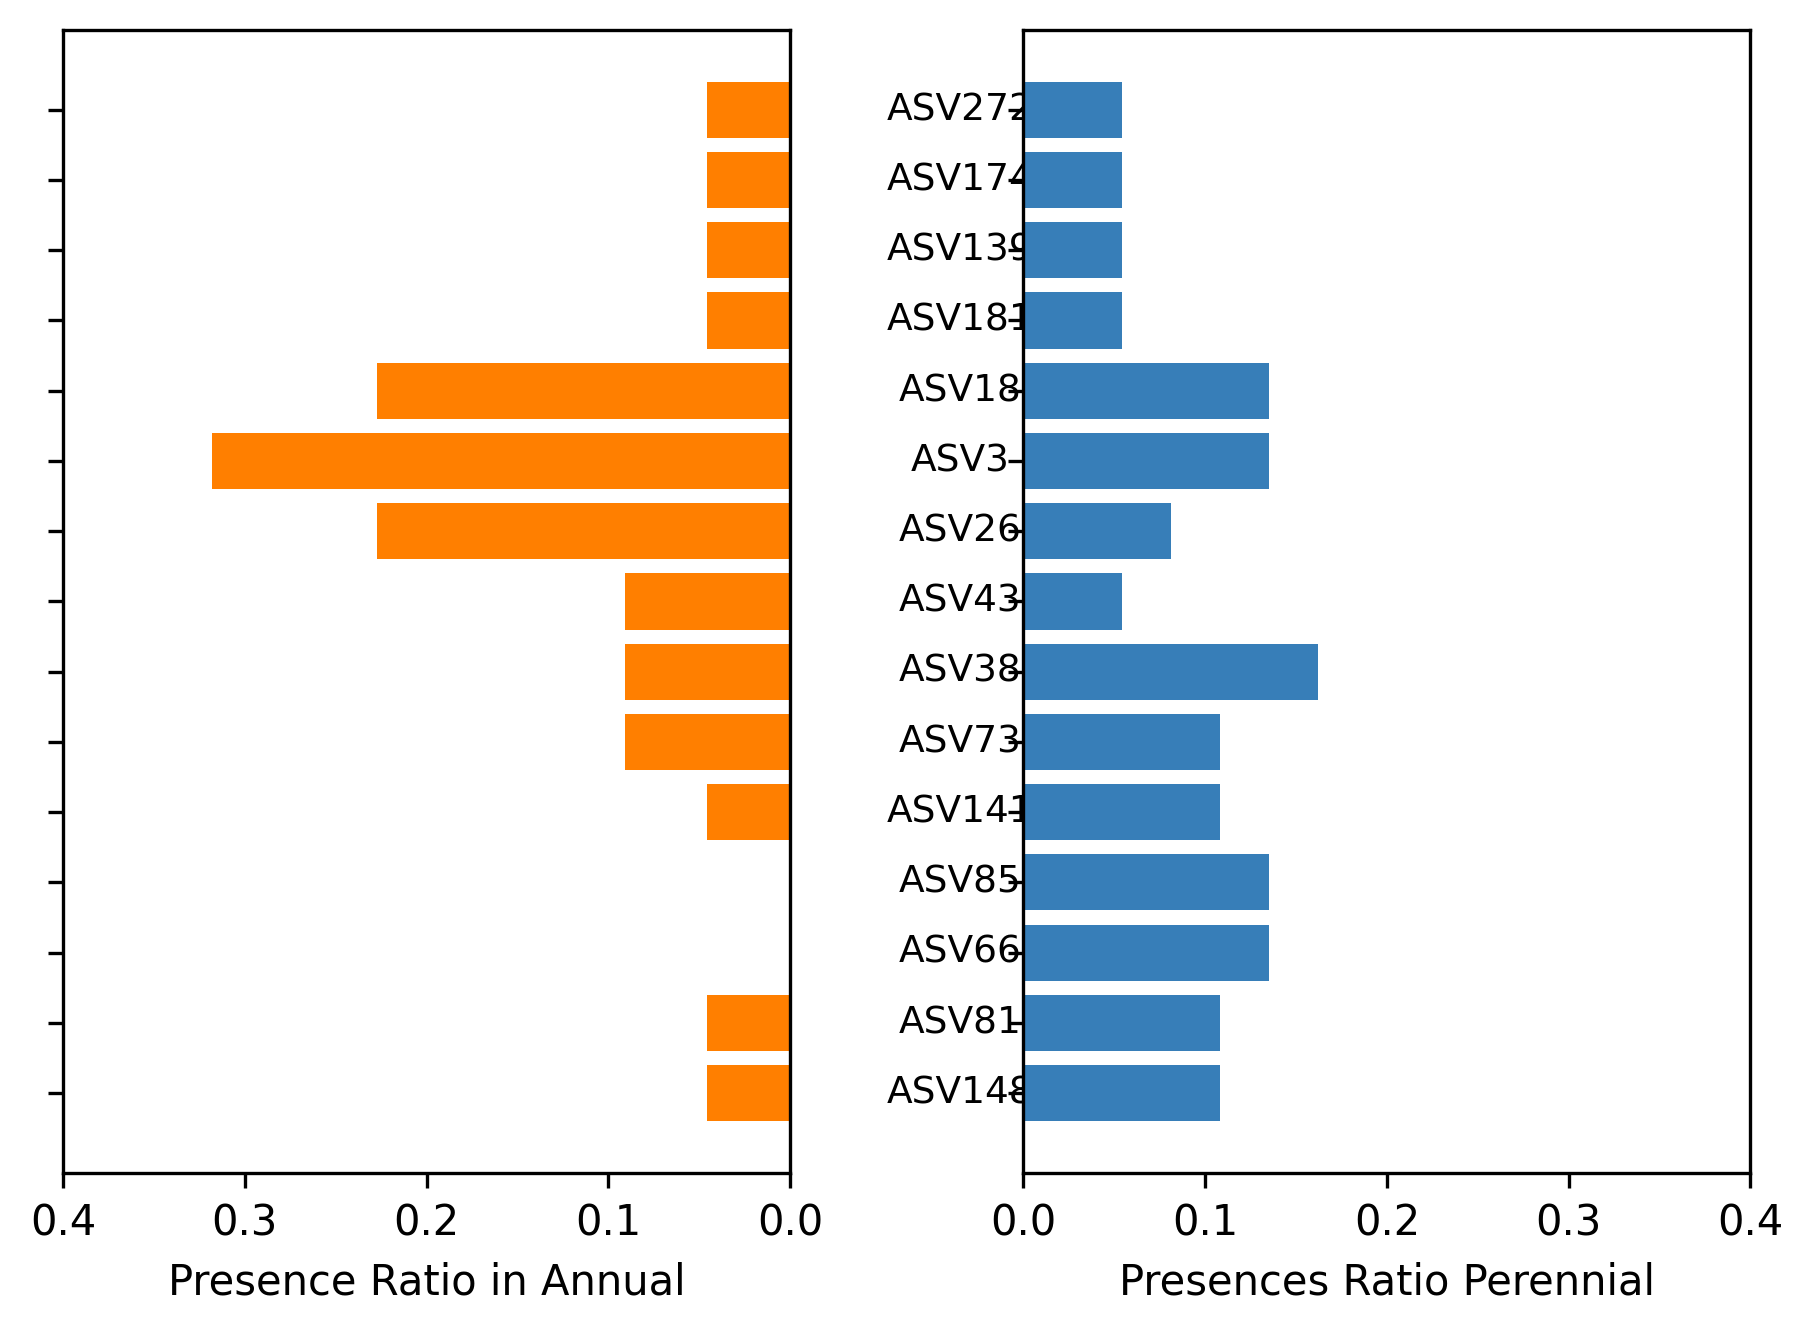

In [29]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

entries=15
selectedOTU_index_15=selectedOTU_index[:entries]
X_FS_15=data[:,selectedOTU_index_15]

df=pd.DataFrame(data=X_FS_15)
selectedASVs=[ASVs[i] for i in selectedOTU_index_15]

targetLabel=burn_label
print(set(targetLabel))
RunML.plotPresenseRatio(X_FS_15,targetLabel,selectedASVs,posLabel="Yes",posText="Burned",negText="Not Burned",entries=entries)

targetLabel=un_label
print(set(targetLabel))
RunML.plotPresenseRatio(X_FS_15,targetLabel,selectedASVs,posLabel="Urban",posText="Natural",negText="Urban",entries=entries)


targetLabel=duration_label
print(set(targetLabel))
RunML.plotPresenseRatio(X_FS_15,targetLabel,selectedASVs,posLabel="Annual",posText="Annual",negText="Perennial",entries=entries)